<a href="https://colab.research.google.com/github/davidfague/Model-Reduction-Methods/blob/main/Extracellular_Potential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stylized Single Cell and Extracellular Potential

#### Download modules from Github

In [ ]:
import os

RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !pip install neuron==8.0.0 &> /dev/null
    os.chdir('/content')
    if not os.path.isdir('Stylized-Single-Cell-and-Extracellular-Potential'):
        !git clone https://github.com/chenziao/Stylized-Single-Cell-and-Extracellular-Potential.git &> /dev/null 
    os.chdir('Stylized-Single-Cell-and-Extracellular-Potential')
    %ls

cell_inference/  Stylized_Single_Cell_Extracellular_Potential_Tutorial.ipynb


## Setup smiulation parameters

In [ ]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import ipywidgets as widgets
from neuron import h
from scipy import signal
from IPython.display import display, clear_output
from ipywidgets import interactive_output, HBox, VBox, Label, Layout
from cell_inference.config import params, paths
from cell_inference.cells.activecell_axon import ReducedOrderL5Cell, ReducedOrderL5CellPassiveDendrite
from cell_inference.utils.currents.ecp import EcpMod
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.plotting.plot_morphology import plot_morphology
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap, plot_lfp_traces
from cell_inference.utils.plotting.plot_variable_with_morphology import plot_variable_with_morphology
from cell_inference.utils.metrics.measure_segment_distance import measure_segment_distance

%matplotlib inline

if RunningInCOLAB:
    os.chdir(paths.COMPILED_REDUCED_ORDER)
    print(os.system('nrnivmodl'))
    os.chdir(os.path.join(paths.ROOT_DIR, '..'))

h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)  # choose the set of mechanisms

h.dt = params.DT  # time step
h.steps_per_ms = 1/h.dt
h.tstop = params.TSTOP  # simulation stop time

0


### Create a cell with stylized morphology and passive dendrites

In [ ]:
# Load biophysical parameters from a json file
filepath = os.path.join(paths.RESOURCES_ROOT, 'biophys_parameters/ReducedOrderL5_passive.json')
with open(filepath) as f:
    biophys_param = json.load(f)
for genome in biophys_param['genome']:
    if genome['value'] != "": genome['value'] = float(genome['value'])

# Load morphology parameters from a csv file
geometry = pd.read_csv(paths.GEO_REDUCED_ORDER, index_col='id')

# Create a cell object
cell = ReducedOrderL5CellPassiveDendrite(geometry=geometry, full_biophys=biophys_param)

# Create synaptic input
stim = h.NetStim()
stim.number = 1  # only one event
stim.start = 2.0  # delay (ms)
gmax = 0.02  # default synapse maximum conductance (uS)
# Add synapse to soma
cell.add_synapse(stim, sec_index=0, gmax=gmax)
# Add synapse to apical tufts
for i in cell.grp_ids[5]:
    cell.add_synapse(stim, sec_index=i, gmax=gmax / cell._nbranch)

# Record time points
t_vec = h.Vector(round(h.tstop / h.dt) + 1).record(h._ref_t)
# Record membrane voltage of all segments
V_rec = Recorder(cell.segments)

### Add electrodes (Neuropixel)
A probe with 384 electrodes [https://www.neuropixels.org/probe](https://www.neuropixels.org/probe). The coordinates of each electrode is a row in the array printed below.

In [ ]:
elec_pos = params.ELECTRODE_POSITION
ecp = EcpMod(cell, elec_pos, min_distance=params.MIN_DISTANCE)  # create an ECP object for extracellular potential

# coordinates (x, y, z) of electrodes
print(params.ELECTRODE_POSITION.shape)
print(params.ELECTRODE_POSITION)

(384, 3)
[[   -8. -1910.     0.]
 [   24. -1910.     0.]
 [  -24. -1890.     0.]
 ...
 [   24.  1890.     0.]
 [  -24.  1910.     0.]
 [    8.  1910.     0.]]


## Custom settings

Using the interactive tools below, you can change the position of the cell, and change the synapse strength and location on the cell.

#### Cell position parameters (x, y, z, alpha, h, phi)
Starting with soma at the origin, apical dendrite along y-axis, rotate and translate the cell to the desired position determined by 6 parameters. First, rotate alpha about the y-axis (spin), then rotate beta=arccos(h) about the x-axis (elevation), then rotate phi about the y-axis (azimuth). Finally translate the cell by (x,y,z).

Use the sliders to change the 6 position parameters. Use the sliders 'elev' and 'azim' to change view of the 3D plot.

In [ ]:
loc_param_default = [0., 0., 80., 0., 1., 0.]  # Default position parameters
elev, azim = 10, -70  # Default view
clr = ['g', 'yellow', 'orange', 'red', 'b', 'c', 'g', 'yellow', 'orange', 'red', 'pink', 'purple']  # section color

def interactive_plot(x, y, z, alpha, beta, phi, elev, azim):
    global loc_param
    loc_param = (x, y, z, np.pi/180*alpha, np.cos(np.pi/180*beta), np.pi/180*phi)
    fig, ax = plot_morphology(cell=cell, electrodes=elec_pos, move_cell=loc_param,
                    elev=-elev, azim=-azim, figsize=(12, 8), clr = clr)
    plt.show()

xslider = Layout(width='500px')
yslider = Layout(height='350px')
w_reset = widgets.Button(description='Reset', icon='history', button_style='primary')
w_x = widgets.FloatSlider(value=loc_param_default[0], min=-200, max=200, step=1, description='x (um)', continuous_update=False, readout_format='.0f')
w_y = widgets.FloatSlider(value=loc_param_default[1], min=-1000, max=1000, step=1, description='y (um)', continuous_update=False, readout_format='.0f')
w_z = widgets.FloatSlider(value=loc_param_default[2], min=20, max=400, step=1, description='z (um)', continuous_update=False, readout_format='.0f')
w_alpha = widgets.FloatSlider(value=180/np.pi*loc_param_default[3], min=-180, max=180, step=1, description='alpha (deg)', continuous_update=False, readout_format='.0f')
w_beta = widgets.FloatSlider(value=180/np.pi*np.arccos(loc_param_default[4]), min=0, max=180, step=1, description='beta (deg)', continuous_update=False, readout_format='.0f')
w_phi = widgets.FloatSlider(value=180/np.pi*loc_param_default[5], min=-180, max=180, step=1, description='phi (deg)', continuous_update=False, readout_format='.0f')
w_elev = widgets.FloatSlider(value=-elev, min=-90, max=90, step=1, description='elev (deg)', continuous_update=False, readout_format='.0f', orientation='vertical', layout=yslider)
w_azim = widgets.FloatSlider(value=-azim, min=-180, max=180, step=1, description='azim (deg)', continuous_update=False, readout_format='.0f', layout=xslider)

def reset_default(*args):
    w_x.value, w_y.value, w_z.value = loc_param_default[:3]
    w_alpha.value = 180 / np.pi * loc_param_default[3]
    w_beta.value = 180 / np.pi * np.arccos(loc_param_default[4])
    w_phi.value = 180 / np.pi * loc_param_default[5]
    w_elev.value, w_azim.value = -elev, -azim
w_reset.on_click(reset_default)

out = interactive_output(interactive_plot, {'x': w_x, 'y': w_y, 'z': w_z, 'alpha': w_alpha, 'beta': w_beta, 'phi': w_phi, 'elev': w_elev, 'azim': w_azim})
ui = VBox([ w_reset, HBox([ VBox([w_x, w_y, w_z]), VBox([w_alpha, w_beta, w_phi]) ]), HBox([ VBox([out, w_azim]), w_elev]) ])

display(ui)

#### Set synaptic input

Use the toggle button to switch synapse location between the soma and the proximal apical tuft dendrite. Use the slider 'Synapse maximal conductance' to change synapse strength.

In [ ]:
w_syn_site = widgets.ToggleButtons(options=['Soma', 'Apical tuft (proximal)'])
w_gmax = widgets.FloatSlider(value=gmax, min=0, max=0.1, step=0.0002, readout_format='.4f')
display(VBox([w_syn_site, HBox([Label('Synapse maximal conductance (uS)'), w_gmax])]))

def set_synapse():
    soma_syn = w_syn_site.value == 'Soma'
    gmax_soma = w_gmax.value if soma_syn else 0
    gmax_tuft = 0 if soma_syn else w_gmax.value / cell._nbranch
    cell.synapse[0].set_gmax(gmax_soma)
    for syn in cell.synapse[1:]:
        syn.set_gmax(gmax_tuft)

## Run simulation and plot results

Run the codes below to simulate and display results everytime after you change the parameters above.

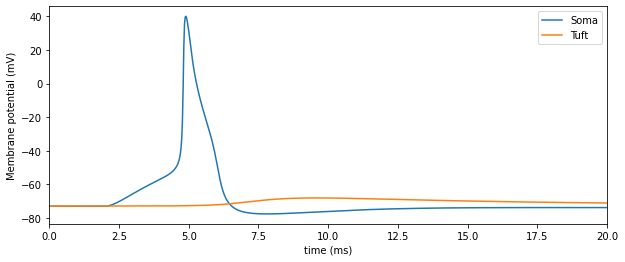

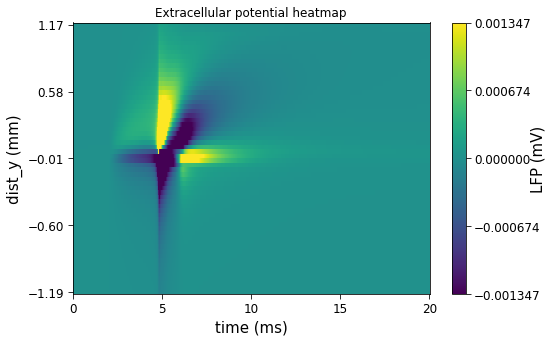

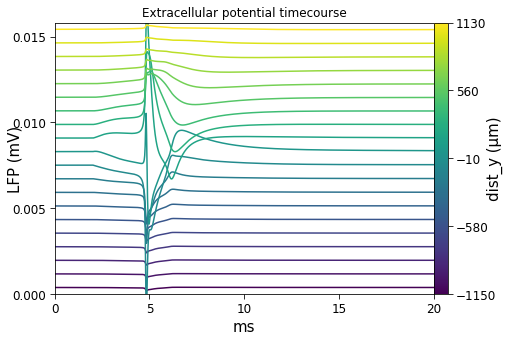

In [ ]:
# Run simulation
set_synapse()
h.run()
# Get results
t = t_vec.as_numpy().copy()  # time array (ms)
# soma membrane potential
Vm = V_rec.as_numpy()
v_soma = Vm[cell.sec_id_in_seg[cell.grp_ids[0][0]]]
v_tfut = Vm[cell.sec_id_in_seg[cell.grp_ids[5][0]]]
# lfp array
lfp = ecp.calc_ecp(move_cell=loc_param).T  # unit: mV

# Soma membrane potential
plt.figure(figsize=(10, 4))
plt.plot(t, v_soma, label='Soma')
plt.plot(t, v_tfut, label='Tuft')
plt.ylabel('Membrane potential (mV)')
plt.xlabel('time (ms)')
plt.xlim(t[[0, -1]])
plt.legend()

# Extracellular potential along y-axis
y_window = [-1200, 1200]  # select range of y coordinate for plotting
ylim = loc_param[1] + np.array(y_window)  # set range of y coordinate
max_idx = np.argmax(np.amax(np.abs(lfp), axis=0))  # find the electrode that records maximum magnitude
x_dist = elec_pos[max_idx, 0]  # x coordinate of the maximum magnitude electrode
e_idx = (elec_pos[:, 0]==x_dist) & (elec_pos[:, 1]>=ylim[0]) & (elec_pos[:, 1]<=ylim[1])  # selected electrode indices

fontsize = 15
labelpad = -10
ticksize = 12
tick_length = 5
nbins = 5
plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=elec_pos[e_idx, 1], lfp=lfp[:, e_idx],
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', axes=plt.gca())
plt.title('Extracellular potential heatmap')
plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, lfp[:, e_idx][:,1::3], electrodes=elec_pos[e_idx][1::3],
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.title('Extracellular potential timecourse')

plt.show()

## Electrotonic distance

Neuron has a tool for electrotonic analysis [https://www.neuron.yale.edu/neuron/static/docs/zclass/zclass.html](https://www.neuron.yale.edu/neuron/static/docs/zclass/zclass.html). It computes the electrotonic distance defined by attenuation, but the classical definition is [anatomical distance/length constant](https://www.neuron.yale.edu/neuron/static/docs/zclass/NIPS94/nipsfin.html).

The plot below shows the membrane potential timecourse at several locations on the cell. The electrotonic distance computed by Neuron of each location is also shown with both number and color. The distance should always be a positive value, but it is labeled negative for the basal dendrites and the axon intentionally so that it can be easily distinguished from the apical dendrites.

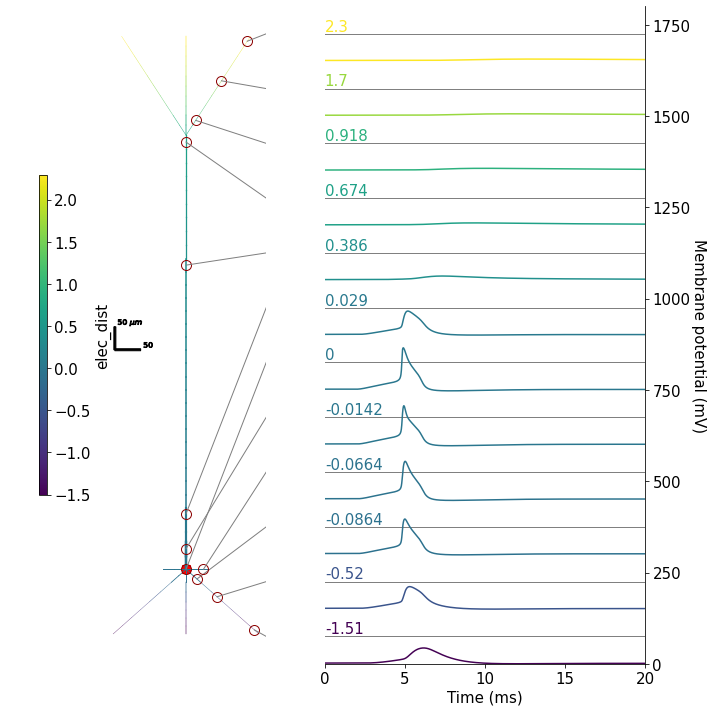

In [ ]:
for syn in cell.synapse:
    syn.set_gmax(0)
h.run()

sec_type_swc = {sec['name']: sec['type'] for _, sec in geometry.iterrows()}
sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in cell.all]
freq = 0 # Hz
seg_prop, _, _ = measure_segment_distance(cell.soma , cell.all, sec_type, freq)

select_seg = [[cell.sec_id_in_seg[sec[0]], cell.get_sec_by_id(sec[0]).nseg -1] for sec in cell.sec_id_lookup.values()]
select_seg = np.sum(np.array(select_seg), axis=1)
# select_seg = np.unique(np.cumsum(np.array(select_seg), axis=1).ravel())
_ = plot_variable_with_morphology(cell.seg_coords, seg_prop, Vm, t=t, axes=['x', 'y'],
                                  distance_type='elec_dist', n_dist=300,
                                  select_seg=select_seg, max_per_dist=1, varname='Membrane potential (mV)',
                                  space=2., normalized_space=True, sort_by_dist=True,
                                  figsize=(10, 10), fontsize=15, scalebar_size=50)

##Transfer Impedance



In [ ]:
import numpy as np
from neuron import h
import cmath

def measure_segment_transfer_impedance(soma, section_list, sec_type, freq=0, extracellular_mechanism=True):
    """
    soma: soma section object
    section_list: list of sections
    sec_type: list of swc type id of sections
    freq: frequency (Hz) at which electrotonic distance is evaluated
    extracellular_mechanism: whether extracellular mechanism is used
    """
    seg_prop = {}
    swc_type = []
    seg_area = []
    seg_dist = []
    seg_length = []
    elec_dist = [] #modulus part of polar form #should change names
    elec_dist0 = [] #modulus of polar form #should change names
    transfer_imps = [] #real part of rectangular form
    transfer_imps0 = [] # real part of rectangular form

    # set up distance origin
    h.distance(0, soma(.5))
    # set up electrotonic origin
    zz = h.Impedance()
    zz.loc(soma(.5))
    if extracellular_mechanism:
        zz.compute(freq + 1 / 9e9, 0) #*
    else:
        zz.compute(freq, 1)
    # measure distance
    for i, sec in enumerate(section_list):
        if sec_type[i]==1:
            transfer_imp=zz.transfer(sec(0.5/sec.nseg)) #*
            transfer_phase=zz.transfer_phase(sec(0.5/sec.nseg)) #*
            elec_dist0.append(transfer_imp) #*
            rect_complex=cmath.rect(transfer_imp,transfer_phase)
            transfer_imps.append(rect_complex.real) #*
        else:
            transfer_imp=zz.transfer(sec.parentseg()) #*
            transfer_phase=zz.transfer_phase(sec.parentseg()) #*
            elec_dist0.append(transfer_imp) #*
            rect_complex=cmath.rect(transfer_imp, transfer_phase) #*
            transfer_imps.append(rect_complex.real) #*
        for j, seg in enumerate(sec):
            swc_type.append(sec_type[i])
            seg_area.append(seg.area())
            seg_dist.append(h.distance(seg))
            seg_length.append(sec.L/sec.nseg)
            if j!=0:
                elec_dist0.append(elec_dist[-1])
                transfer_imps.append(transfer_imps0[-1])
            elec_dist.append(zz.transfer(seg)) #*
            transfer_imp=zz.transfer(seg) #*
            transfer_phase=zz.transfer_phase(seg) #*
            rect_complex=cmath.rect(transfer_imp,transfer_phase) #*
            transfer_imps0.append(rect_complex.real) #*

    seg_prop['swc_type'] = np.array(swc_type)
    seg_prop['seg_area'] = np.array(seg_area)

    # distance at endpoints of each segment
    seg_prop['distance'] = np.expand_dims(seg_dist, 1) + np.expand_dims(seg_length, 1) / 2 * np.array([[-1, 1]])
    # seg_prop['transfer_imp'] = np.sort(np.log(elec_dist0[0]) - np.log(np.column_stack([elec_dist0, elec_dist])), axis=1) #*
    seg_prop['transfer_imp_mod'] = np.sort(elec_dist0[0] - np.column_stack([elec_dist0, elec_dist]), axis=1) #*
    seg_prop['transfer_imp_real'] = np.sort(transfer_imps[0] - np.column_stack([transfer_imps, transfer_imps0]), axis=1) #*


    # change sign of basal and axon types
    idx = np.nonzero((seg_prop['swc_type']==2) | (seg_prop['swc_type']==3))[0]
    seg_prop['distance'][idx] = -seg_prop['distance'][idx,::-1]
    seg_prop['transfer_imp_mod'][idx] = -seg_prop['transfer_imp_mod'][idx,::-1] #*
    seg_prop['transfer_imp_real'][idx] = -seg_prop['transfer_imp_real'][idx,::-1] #*
    return seg_prop, zz.transfer(soma(.5)), zz.transfer_phase(soma(.5))


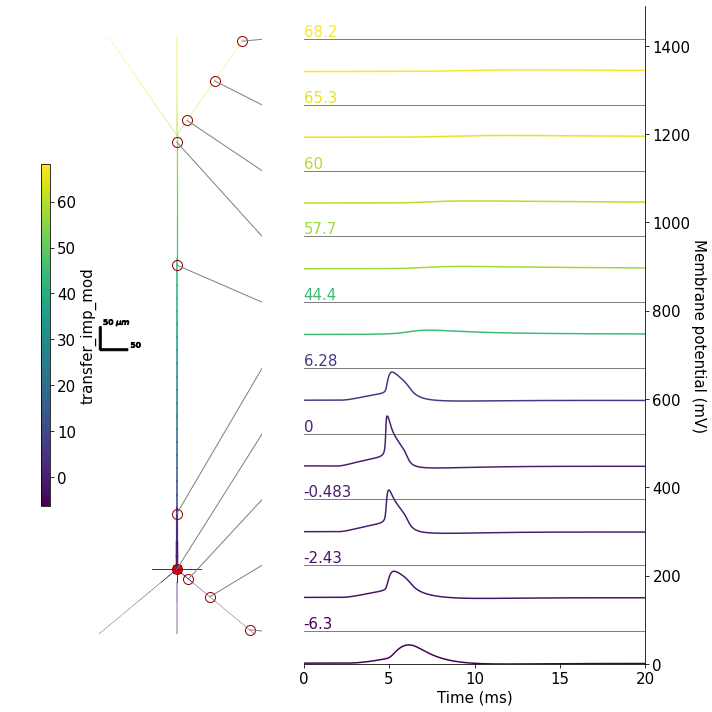

In [ ]:
#using modulus of polar form

for syn in cell.synapse:
    syn.set_gmax(0)
h.run()

sec_type_swc = {sec['name']: sec['type'] for _, sec in geometry.iterrows()}
sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in cell.all]
freq = 0 # Hz
seg_prop, _, _ = measure_segment_transfer_impedance(cell.soma , cell.all, sec_type, freq)

select_seg = [[cell.sec_id_in_seg[sec[0]], cell.get_sec_by_id(sec[0]).nseg -1] for sec in cell.sec_id_lookup.values()]
select_seg = np.sum(np.array(select_seg), axis=1)
# select_seg = np.unique(np.cumsum(np.array(select_seg), axis=1).ravel())
_ = plot_variable_with_morphology(cell.seg_coords, seg_prop, Vm, t=t, axes=['x', 'y'],
                                  distance_type='transfer_imp_mod', n_dist=300,
                                  select_seg=select_seg, max_per_dist=1, varname='Membrane potential (mV)',
                                  space=2., normalized_space=True, sort_by_dist=True,
                                  figsize=(10, 10), fontsize=15, scalebar_size=50)

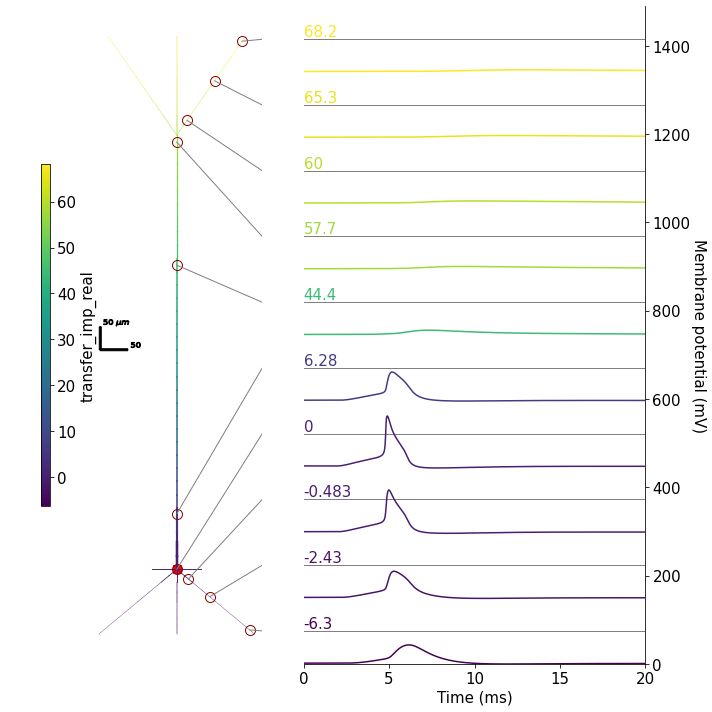

In [ ]:
#using real part of rectangular complex form

for syn in cell.synapse:
    syn.set_gmax(0)
h.run()

sec_type_swc = {sec['name']: sec['type'] for _, sec in geometry.iterrows()}
sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in cell.all]
freq = 0 # Hz
seg_prop, _, _ = measure_segment_transfer_impedance(cell.soma , cell.all, sec_type, freq)

select_seg = [[cell.sec_id_in_seg[sec[0]], cell.get_sec_by_id(sec[0]).nseg -1] for sec in cell.sec_id_lookup.values()]
select_seg = np.sum(np.array(select_seg), axis=1)
# select_seg = np.unique(np.cumsum(np.array(select_seg), axis=1).ravel())
_ = plot_variable_with_morphology(cell.seg_coords, seg_prop, Vm, t=t, axes=['x', 'y'],
                                  distance_type='transfer_imp_real', n_dist=300,
                                  select_seg=select_seg, max_per_dist=1, varname='Membrane potential (mV)',
                                  space=2., normalized_space=True, sort_by_dist=True,
                                  figsize=(10, 10), fontsize=15, scalebar_size=50)

Transfer Impedance is a complex number

In [ ]:
polar_modulus=1
polar_phase=3

complex_rectangular_form=cmath.rect(polar_modulus, polar_phase)
print(complex_rectangular_form)

(-0.9899924966004454+0.1411200080598672j)


In [ ]:
complex_rectangular_form.real

-0.9899924966004454